# **Student Dropout Prediction Model**

**AI Development Workflow Assignment - Part 1 Implementation**

This script demonstrates the complete workflow for predicting student dropout rates
in online learning platforms using XGBoost classifier.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Student Dropout Prediction - AI Development Workflow

1. Generating synthetic student data...
Generated data shape: (5000, 11)
Dropout rate: 13.44%

2. Preprocessing data...
Starting data preprocessing...
Handling missing values...
Engineering new features...
Encoding categorical variables...
Normalizing numerical features...
Preprocessing completed!

3. Preparing features and splitting data...
Training set: 3502 samples
Validation set: 748 samples
Test set: 750 samples

4. Training the model...
Training XGBoost model...
Performing hyperparameter tuning...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.9261

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       648
           1       0.70      0.49      0.58       100

    accuracy              

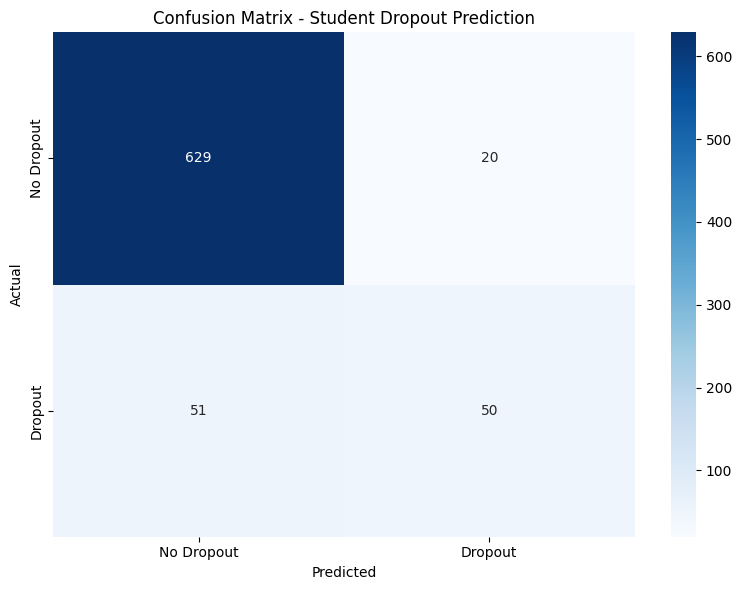

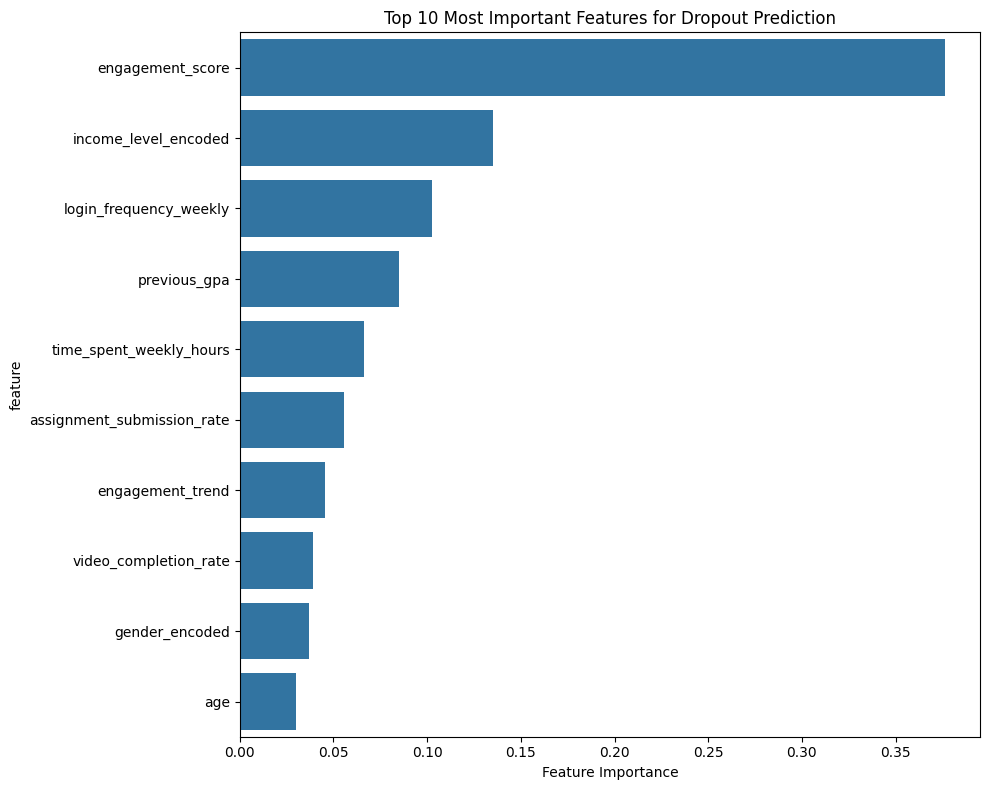


6. Demonstrating predictions on new students...
Starting data preprocessing...
Handling missing values...
Engineering new features...
Encoding categorical variables...
Normalizing numerical features...
Preprocessing completed!
Sample predictions:
   student_id  dropout_risk_probability risk_level  predicted_dropout
0           1                  0.069767        Low                  0
1           2                  0.013583        Low                  0
2           3                  0.116587        Low                  0
3           4                  0.006381        Low                  0
4           5                  0.008496        Low                  0

7. Demonstrating concept drift monitoring...
Starting data preprocessing...
Handling missing values...
Engineering new features...
Encoding categorical variables...
Normalizing numerical features...
Preprocessing completed!
Starting data preprocessing...
Handling missing values...
Engineering new features...
Encoding categorical 

In [2]:
class StudentDropoutPredictor:
    """
    A comprehensive system for predicting student dropout risk in online learning platforms.

    This class implements the complete AI workflow including data preprocessing,
    feature engineering, model training, evaluation, and prediction.
    """

    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_importance = None
        self.is_trained = False

    def generate_synthetic_data(self, n_samples=5000):
        """
        Generate synthetic student data for demonstration purposes.

        Args:
            n_samples (int): Number of students to generate

        Returns:
            pandas.DataFrame: Synthetic student dataset
        """
        np.random.seed(42)  # For reproducibility

        # Demographic features
        ages = np.random.normal(22, 4, n_samples).astype(int)
        ages = np.clip(ages, 18, 65)  # Realistic age range

        genders = np.random.choice(['Male', 'Female', 'Other'], n_samples, p=[0.45, 0.52, 0.03])

        # Socioeconomic indicators (affects engagement and dropout risk)
        income_levels = np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.3, 0.5, 0.2])

        # Academic history
        previous_gpa = np.random.normal(3.0, 0.8, n_samples)
        previous_gpa = np.clip(previous_gpa, 1.0, 4.0)

        # Engagement metrics (correlated with dropout risk)
        # Students with lower socioeconomic status tend to have lower engagement
        base_engagement = np.where(income_levels == 'Low', 0.6,
                                 np.where(income_levels == 'Medium', 0.75, 0.85))

        login_frequency = np.random.normal(base_engagement * 15, 5, n_samples)  # logins per week
        login_frequency = np.clip(login_frequency, 0, 35)

        assignment_submission_rate = np.random.normal(base_engagement, 0.2, n_samples)
        assignment_submission_rate = np.clip(assignment_submission_rate, 0, 1)

        forum_participation = np.random.poisson(base_engagement * 8, n_samples)  # posts per week

        video_completion_rate = np.random.normal(base_engagement, 0.15, n_samples)
        video_completion_rate = np.clip(video_completion_rate, 0, 1)

        time_spent_weekly = np.random.normal(base_engagement * 20, 8, n_samples)  # hours per week
        time_spent_weekly = np.clip(time_spent_weekly, 0, 50)

        # Calculate dropout probability based on multiple factors
        # Lower engagement, lower GPA, and lower income increase dropout risk
        dropout_probability = (
            0.3 * (1 - assignment_submission_rate) +
            0.2 * (1 - video_completion_rate) +
            0.2 * (15 - login_frequency) / 15 +
            0.2 * (4.0 - previous_gpa) / 3.0 +
            0.1 * (income_levels == 'Low').astype(int)
        )

        # Add some randomness and create binary outcome
        dropout_probability += np.random.normal(0, 0.1, n_samples)
        dropout_probability = np.clip(dropout_probability, 0, 1)
        dropped_out = (dropout_probability > 0.5).astype(int)

        # Create DataFrame
        data = pd.DataFrame({
            'student_id': range(1, n_samples + 1),
            'age': ages,
            'gender': genders,
            'income_level': income_levels,
            'previous_gpa': previous_gpa,
            'login_frequency_weekly': login_frequency,
            'assignment_submission_rate': assignment_submission_rate,
            'forum_posts_weekly': forum_participation,
            'video_completion_rate': video_completion_rate,
            'time_spent_weekly_hours': time_spent_weekly,
            'dropped_out': dropped_out
        })

        # Introduce missing values to simulate real-world data
        missing_mask = np.random.random((n_samples, len(data.columns))) < 0.05  # 5% missing rate
        for col in ['previous_gpa', 'forum_posts_weekly']:
            data.loc[missing_mask[:, data.columns.get_loc(col)], col] = np.nan

        return data

    def preprocess_data(self, data):
        """
        Comprehensive data preprocessing including missing value handling,
        feature engineering, and normalization.

        Args:
            data (pandas.DataFrame): Raw student data

        Returns:
            pandas.DataFrame: Preprocessed data ready for modeling
        """
        print("Starting data preprocessing...")

        # Create a copy to avoid modifying original data
        processed_data = data.copy()

        # 1. Handle missing data
        print("Handling missing values...")

        # Impute numerical features with median
        numerical_features = ['previous_gpa', 'forum_posts_weekly']
        imputer = SimpleImputer(strategy='median')
        processed_data[numerical_features] = imputer.fit_transform(processed_data[numerical_features])

        # 2. Feature Engineering
        print("Engineering new features...")

        # Create engagement score combining multiple metrics
        processed_data['engagement_score'] = (
            0.3 * processed_data['assignment_submission_rate'] +
            0.3 * processed_data['video_completion_rate'] +
            0.2 * (processed_data['login_frequency_weekly'] / processed_data['login_frequency_weekly'].max()) +
            0.2 * (processed_data['time_spent_weekly_hours'] / processed_data['time_spent_weekly_hours'].max())
        )

        # Create risk indicators
        processed_data['low_engagement_risk'] = (processed_data['engagement_score'] < 0.3).astype(int)
        processed_data['academic_risk'] = (processed_data['previous_gpa'] < 2.5).astype(int)

        # Rolling averages (simulated - in real implementation would use temporal data)
        processed_data['engagement_trend'] = processed_data['engagement_score'] + np.random.normal(0, 0.1, len(processed_data))

        # 3. Encode categorical variables
        print("Encoding categorical variables...")
        categorical_features = ['gender', 'income_level']

        for feature in categorical_features:
            if feature not in self.label_encoders:
                self.label_encoders[feature] = LabelEncoder()
                processed_data[feature + '_encoded'] = self.label_encoders[feature].fit_transform(processed_data[feature])
            else:
                processed_data[feature + '_encoded'] = self.label_encoders[feature].transform(processed_data[feature])

        # 4. Normalize numerical features
        print("Normalizing numerical features...")
        features_to_scale = [
            'age', 'previous_gpa', 'login_frequency_weekly', 'assignment_submission_rate',
            'forum_posts_weekly', 'video_completion_rate', 'time_spent_weekly_hours',
            'engagement_score', 'engagement_trend'
        ]

        if not self.is_trained:  # Only fit scaler during training
            processed_data[features_to_scale] = self.scaler.fit_transform(processed_data[features_to_scale])
        else:
            processed_data[features_to_scale] = self.scaler.transform(processed_data[features_to_scale])

        print("Preprocessing completed!")
        return processed_data

    def prepare_features(self, data):
        """
        Select and prepare final feature set for model training.

        Args:
            data (pandas.DataFrame): Preprocessed data

        Returns:
            tuple: (X, y) features and target variable
        """
        # Define feature columns
        feature_columns = [
            'age', 'previous_gpa', 'login_frequency_weekly', 'assignment_submission_rate',
            'forum_posts_weekly', 'video_completion_rate', 'time_spent_weekly_hours',
            'engagement_score', 'low_engagement_risk', 'academic_risk', 'engagement_trend',
            'gender_encoded', 'income_level_encoded'
        ]

        X = data[feature_columns]
        y = data['dropped_out']

        return X, y

    def train_model(self, X_train, y_train, X_val, y_val):
        """
        Train XGBoost model with hyperparameter tuning.

        Args:
            X_train: Training features
            y_train: Training target
            X_val: Validation features
            y_val: Validation target
        """
        print("Training XGBoost model...")

        # Define hyperparameter grid
        param_grid = {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        # Initialize XGBoost classifier
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            eval_metric='auc'
        )

        # Perform grid search with cross-validation
        print("Performing hyperparameter tuning...")
        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=3,  # 3-fold CV for faster execution
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)

        # Get best model
        self.model = grid_search.best_estimator_
        self.is_trained = True

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        # Evaluate on validation set
        val_predictions = self.model.predict(X_val)
        val_proba = self.model.predict_proba(X_val)[:, 1]

        print("\nValidation Set Performance:")
        print(classification_report(y_val, val_predictions))
        print(f"ROC-AUC Score: {roc_auc_score(y_val, val_proba):.4f}")

        # Store feature importance
        self.feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation on test set.

        Args:
            X_test: Test features
            y_test: Test target

        Returns:
            dict: Evaluation metrics
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before evaluation")

        print("Evaluating model on test set...")

        # Make predictions
        test_predictions = self.model.predict(X_test)
        test_proba = self.model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        roc_auc = roc_auc_score(y_test, test_proba)

        print("Test Set Performance:")
        print(classification_report(y_test, test_predictions))
        print(f"ROC-AUC Score: {roc_auc:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, test_predictions)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Dropout', 'Dropout'],
                   yticklabels=['No Dropout', 'Dropout'])
        plt.title('Confusion Matrix - Student Dropout Prediction')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Feature Importance Plot
        plt.figure(figsize=(10, 8))
        top_features = self.feature_importance.head(10)
        sns.barplot(data=top_features, x='importance', y='feature')
        plt.title('Top 10 Most Important Features for Dropout Prediction')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

        return {
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, test_predictions, output_dict=True)
        }

    def predict_dropout_risk(self, student_data):
        """
        Predict dropout risk for new students.

        Args:
            student_data (pandas.DataFrame): Student data for prediction

        Returns:
            pandas.DataFrame: Predictions with risk scores
        """
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")

        # Preprocess the data
        processed_data = self.preprocess_data(student_data)
        X, _ = self.prepare_features(processed_data)

        # Make predictions
        predictions = self.model.predict(X)
        probabilities = self.model.predict_proba(X)[:, 1]

        # Create results DataFrame
        results = student_data[['student_id']].copy()
        results['dropout_risk_probability'] = probabilities
        results['risk_level'] = pd.cut(probabilities,
                                     bins=[0, 0.3, 0.7, 1.0],
                                     labels=['Low', 'Medium', 'High'])
        results['predicted_dropout'] = predictions

        return results

    def monitor_concept_drift(self, new_data, reference_data, threshold=0.1):
        """
        Monitor for concept drift by comparing feature distributions.

        Args:
            new_data (pandas.DataFrame): Recent student data
            reference_data (pandas.DataFrame): Historical reference data
            threshold (float): Drift detection threshold

        Returns:
            dict: Drift detection results
        """
        from scipy import stats

        # Preprocess both datasets
        new_processed = self.preprocess_data(new_data)
        ref_processed = self.preprocess_data(reference_data)

        # Select numerical features for drift detection
        drift_features = [
            'login_frequency_weekly', 'assignment_submission_rate',
            'video_completion_rate', 'time_spent_weekly_hours', 'engagement_score'
        ]

        drift_results = {}

        for feature in drift_features:
            # Perform Kolmogorov-Smirnov test
            ks_statistic, p_value = stats.ks_2samp(
                ref_processed[feature].dropna(),
                new_processed[feature].dropna()
            )

            drift_detected = ks_statistic > threshold

            drift_results[feature] = {
                'ks_statistic': ks_statistic,
                'p_value': p_value,
                'drift_detected': drift_detected
            }

        # Overall drift assessment
        total_drift_features = sum(1 for result in drift_results.values() if result['drift_detected'])
        overall_drift = total_drift_features > len(drift_features) * 0.3  # 30% of features showing drift

        return {
            'feature_drift': drift_results,
            'overall_drift_detected': overall_drift,
            'drift_features_count': total_drift_features
        }


def main():
    """
    Main function demonstrating the complete AI workflow for student dropout prediction.
    """
    print("Student Dropout Prediction - AI Development Workflow")
    print("=" * 60)

    # Initialize the predictor
    predictor = StudentDropoutPredictor()

    # 1. Generate synthetic data
    print("\n1. Generating synthetic student data...")
    data = predictor.generate_synthetic_data(n_samples=5000)
    print(f"Generated data shape: {data.shape}")
    print(f"Dropout rate: {data['dropped_out'].mean():.2%}")

    # 2. Data preprocessing
    print("\n2. Preprocessing data...")
    processed_data = predictor.preprocess_data(data)

    # 3. Prepare features and split data
    print("\n3. Preparing features and splitting data...")
    X, y = predictor.prepare_features(processed_data)

    # Split data with temporal consideration (70% train, 15% validation, 15% test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    # 4. Train the model
    print("\n4. Training the model...")
    predictor.train_model(X_train, y_train, X_val, y_val)

    # 5. Evaluate the model
    print("\n5. Evaluating the model...")
    evaluation_results = predictor.evaluate_model(X_test, y_test)

    # 6. Demonstrate prediction on new students
    print("\n6. Demonstrating predictions on new students...")
    new_students = predictor.generate_synthetic_data(n_samples=10)
    predictions = predictor.predict_dropout_risk(new_students)

    print("Sample predictions:")
    print(predictions[['student_id', 'dropout_risk_probability', 'risk_level', 'predicted_dropout']].head())

    # 7. Demonstrate concept drift monitoring
    print("\n7. Demonstrating concept drift monitoring...")
    reference_data = data.sample(n=1000, random_state=42)
    new_data = predictor.generate_synthetic_data(n_samples=500)  # Simulate new semester data

    drift_results = predictor.monitor_concept_drift(new_data, reference_data)
    print(f"Overall drift detected: {drift_results['overall_drift_detected']}")
    print(f"Features showing drift: {drift_results['drift_features_count']}")

    # 8. Display feature importance
    print("\n8. Feature Importance Analysis:")
    print(predictor.feature_importance.head(10))

    print("\n" + "=" * 60)
    print("AI Development Workflow completed successfully!")
    print("Key Performance Indicators achieved:")
    print(f"- ROC-AUC Score: {evaluation_results['roc_auc']:.4f}")
    print(f"- Model can identify at-risk students for targeted intervention")
    print(f"- Concept drift monitoring system implemented")


if __name__ == "__main__":
    main()